## MVG 1 - the Multivariate Gaussian Distribution - Section 2, 4/17

A Multivariate Gaussian Distribution is a probability distribution.  It is similar to a Gaussian or Normal distribution, but in more than one dimension.  Thus, it could have different variances on different axes.  Also, the axes of the distribution could be rotated in some way, so there is a matrix of covariances instead of just an x variance and a y variance.  The diagonal entries of the covariance matrix are the variances of x, y, etc., while the off-diagonal entries are correlations between x, y, etc.  Furthermore, the eigenvectors of the covariance matrix are the major and minor axes of the ellipsoids formed by the isocontours of the MVG distribution.  (The isocontours of the MVG distribution are curves of constant probability.)  Thus, the eigenvector with the largest eigenvalue (the "first principal component") is the direction of maximum variance of the probability distribution.

In the plot below, the color is an indicator of probability density.  The yellow region at the center is highly probable, while the blue region surrounding it is highly improbable.

<IPython.core.display.Javascript object>


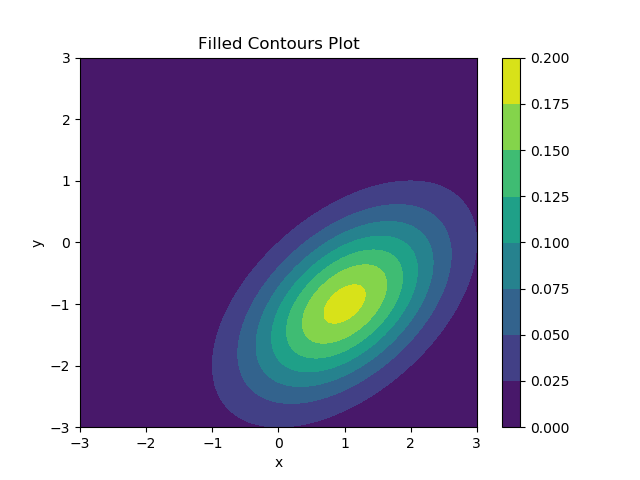

In [183]:
# 4. Plotting Isocontours

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

mu = np.array([1, -1])  # mean
Sigma = np.array([[1, 0.5], [0.5, 1]])  # covariance matrix 

# Get all eigenvalues greater than zero
def eigvals_gt_0(x):
    return np.all(np.linalg.eigvals(x) > 0)

# Is the matrix symmetric?
def symmetric(x):
    return np.array_equal(x, x.T)

# mu is a vector of means for a MVG distribution
# Sigma are the covariances
# This function checks vector mu and matrix Sigma to make sure they are
# of the right dimension, n = 2, so that we can plot it,
# and that Sigma is positive definite.
def check_mu_Sigma(mu, Sigma):

    n = mu.shape[0]
    if not np.array_equal(mu.shape, np.array([n])):
        print("Wrong mu shape")
        return False
    if not np.array_equal(Sigma.shape, np.array([n, n])):
        print("Wrong Sigma shape")
        return False
    if n != 2:
        print("Dimension must equal 2, so that we can plot the distribution")
        return False
    if not eigvals_gt_0(Sigma):
        print("Sigma is not positive definite: eigenvalues are not all > 0")
        return False
    if not symmetric(Sigma):
        print("Sigma is not positive definite: it is not symmetric")
        return False
    return True

def plot_Gaussian(mu, Sigma, xmin, xmax, ymin, ymax):
    
    check_mu_Sigma(mu, Sigma)

    xlist = np.linspace(xmin, xmax, 100)
    ylist = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(xlist, ylist)

    vecfunc = np.vectorize(lambda x, y: np.exp(- 0.5 * (np.array([x, y]) - mu).T\
                                               .dot(np.linalg.inv(Sigma))\
                                               .dot(np.array([x, y]) - mu)))
    n = mu.shape[0]
    Z = 1 / ((2 * np.pi)**(n/2) * np.linalg.det(Sigma)**0.5) * \
        vecfunc(X, Y)
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Filled Contours Plot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    
plot_Gaussian(mu, Sigma, -3.0, 3.0, -3.0, 3.0)

In [184]:
# 2. Computing the covariance matrix of a vector random variable
# We create a multivariate normal distribution with a particular covariance matrix Sigma
# Then, we use equation (1) from the notes to extract Sigma from a 
# random sample of that random variable
# If we have enough samples s, then the computed covariance matrix
# should be approximately equal to Sigma

import scipy.stats as stats

# Generates s samples with mean mu and covariance matrix Sigma.
# Then return an estimate of Sigma from these samples.
def cov_matrix(mu, Sigma, s):
      
    check_mu_Sigma(mu, Sigma)
    
    X = stats.multivariate_normal(mean=mu, cov=Sigma)
    samp = np.array(X.rvs(size = s))
    sh = samp.shape
    
    # q1 = E[X X^T]
    # q2 = mu mu^T
    n = mu.shape[0]
    q1 = np.zeros([n, n])
    for i in range(s):
        q1 += np.outer(samp[i,:], samp[i,:])
    m = samp.mean(axis = 0)
    q2 = np.outer(m, m)
    return q1 / s - q2
            
cov_matrix(mu, Sigma, 1000)  # estimated Sigma

array([[0.95919398, 0.49757904],
       [0.49757904, 0.98251894]])

In [185]:
Sigma # exact Sigma; should be approximately equal to estimated Sigma

array([[1. , 0.5],
       [0.5, 1. ]])

## MVG 2 - More on Multivariate Gaussians - Section 2, 4/17

In this section, we compute the sum of independent Gaussians, the marginal of a joint Gaussian, and the conditional of a joint Gaussian. 

The sum means that e.g. we have two two-dimensional MVGs (say the dimensions are x, y) and we want to predict the distribution of their sum.

The marginal means that e.g. we have a four-dimensional MVG (say the dimensions are x, y, z, w) and we want to predict the distribution of x and y. 

The conditional means that e.g. we have a four-dimensional MVG (say the dimensions are x, y, z, w) and we want to predict the distribution of x and y given that e.g. (z, w) = (0, 0).

In each of these cases, the target distribution is two-dimensional.

In [186]:
# We will make comparisons between distributions using a two-dimensional histogram.
# The sum, marginal, and conditional distributions are each two-dimensional.
# The range in x and y is specified, along with the number of bins m in the x dimension 
# and the number of bins n in the y dimension.
def hist2d(sample, x1, y1, x2, y2, m, n):
    arr = np.zeros([m, n])
    for samp in sample:
        if x1 <= samp[0] and samp[0] < x2 and \
           y1 <= samp[1] and samp[1] < y2:
            arr[int((samp[0] - x1) / (x2 - x1) * m), \
                int((samp[1] - y1) / (y2 - y1) * n)] += 1
    return arr

def compare_hists(hist1, hist2):
    print("Difference of histograms:", np.abs(hist1 - hist2).sum(axis = None))
    print("Sum of histograms:", np.abs(hist1 + hist2).sum(axis = None))
    print("If difference << sum, then the histograms are similar")

### Sum of independent Gaussians

In [214]:
# We assert that the sum of two independent Gaussians 1 and 2 has a mean equal to the
# sum of the two means and a covariance equal to the sum of the two covariances.

# Construct two independent gaussians with difference means and covariances

mu_1 = np.array([1, -1])
mu_2 = np.array([0, 0])

Sigma_1 = np.array([[1, 0.5], [0.5, 1]])
Sigma_2 = np.array([[1, 0], [0, 1]])

s = 100000  # Number of samples

X = stats.multivariate_normal(mean = mu_1, cov = Sigma_1)
Y = stats.multivariate_normal(mean = mu_2, cov = Sigma_2)

# Find the sum empirically by sampling both gaussians and adding the results

sum_empirical_sample = X.rvs(s) + Y.rvs(s)

sum_empirical_hist = hist2d(sum_empirical_sample, -5, -5, 5, 5, 10, 10)

In [215]:
# The mean and covariance of the summed distribution are the sum of the mean and
# covariance for the two distributions.  This is known because mean and covariance
# sum for independent distributions.
# What's harder to show is that the summed distribution is in fact a Gaussian.  The notes
# say that this is too hard to show, and they just assert it.
sum_pred_rv = stats.multivariate_normal(mean = (mu_1 + mu_2), cov = (Sigma_1 + Sigma_2))
sum_pred_hist = hist2d(sum_pred_rv.rvs(s), -5, -5, 5, 5, 10, 10)

In [216]:
compare_hists(sum_empirical_hist, sum_pred_hist)

Difference of histograms: 1930.0
Sum of histograms: 199080.0
If difference << sum, then the histograms are similar


### Marginal of a joint Gaussian

In [217]:
from scipy.stats.contingency import margins

In [218]:
# This time, the Gaussian has one big (4 dimensional) covariance matrix.  The four dimensions
# are divided into A and B dimensions.  That is, if the dimensions are x, y, z, w, then
# x_A = x and y while x_B = z and w.
# We have to take the marginal distribution: that is, if we know the distribution of the 
# big Gaussian, what is the distribution of x_A, the first two of the four coordinates?  
# The notes say that its mean is mu_A, the first two elements of the mean vector, and its 
# covariance is Sigma_AA, the 2 by 2 upper left corner of the big covariance matrix.

mu_A = np.array([1, -1])
mu_B = np.array([0, 0])
mu = np.concatenate((mu_A, mu_B))

Sigma_AA = np.array([[1, 0.5], [0.5, 1]])
Sigma_AB = np.array([[0.3, 0.3],[0.3, 0.3]])
Sigma_BA = Sigma_AB.T
Sigma_BB = np.array([[1, 0], [0, 1]])

Sigma = np.concatenate((np.concatenate((Sigma_AA, Sigma_AB), axis = 1), \
                       np.concatenate((Sigma_BA, Sigma_BB), axis = 1)), axis = 0)

In [219]:
X = stats.multivariate_normal(mean = mu, cov = Sigma)

In [220]:
marg_empirical_sample = X.rvs(s)
marg_empirical_hist = hist2d([x[0:2] for x in marg_empirical_sample], -5, -5, 5, 5, 10, 10)

marg_pred_rv = stats.multivariate_normal(mean = mu_A, cov = Sigma_AA)
marg_pred_hist = hist2d(marg_pred_rv.rvs(s), -5, -5, 5, 5, 10, 10)

In [221]:
compare_hists(marg_empirical_hist, marg_pred_hist)

Difference of histograms: 1724.0
Sum of histograms: 199984.0
If difference << sum, then the histograms are similar


### Conditional of a joint Gaussian

In [222]:
# This is the empirical distribution of x_B given that x_A == 0
# To approximate this, we consider all samples for which x_A's two coordinates are between
# -0.1 and 0.1 of its center mu_A = [1, -1]
# We didn't have to pick the center though; we could have picked another value of x_A
x_A = mu_A
cond_empirical_hist = hist2d([x[2:] for x in marg_empirical_sample if x[0] > x_A[0]-0.1 and x[0] < x_A[0]+0.1 and x[1] > x_A[1]-0.1 and x[1] < x_A[1]+0.1], -5, -5, 5, 5, 10, 10)

In [223]:
# Count the number of samples that we have selected
s2 = cond_empirical_hist.sum(axis = None)
print(s2)

730.0


In [224]:
# This is the predicted distribution of x_B given x_A == 0
# It has a rather complicated formula that is given in the notes.
# Note that the covariance of x_B is independent of the value of x_A
# This fact was counterintuitive for me.  Keep in mind that the covariance of x_B is
# normalized by the probability that x_B takes on a certain value.
# The mean, however, is dependent on the value of x_A.
cond_pred = stats.multivariate_normal(mean = mu_B + Sigma_BA.dot(np.linalg.inv(Sigma_AA)).dot(x_A - mu_A), \
                      cov = Sigma_BB - Sigma_BA.dot(np.linalg.inv(Sigma_AA)).dot(Sigma_AB))

In [225]:
# Create a histogram of s2 samples with the predicted distribution
cond_pred_hist = hist2d(cond_pred.rvs(int(s2)), -5, -5, 5, 5, 10, 10)

In [226]:
compare_hists(cond_empirical_hist, cond_pred_hist)

Difference of histograms: 112.0
Sum of histograms: 1460.0
If difference << sum, then the histograms are similar


## MVG 3 - Part IV - Generative Learning algorithms - Lecture 5, 4/20
#### 1. Gaussian discriminant analysis

In this model, two MVGs, MVG 0 and MVG 1, have the same covariance matrix, Sigma, but different means, mu_0 and mu_1.  We generate a bunch of data with them, where we know which sample belongs to which group.  We then estimate the means and covariance matrix from the data samples.  The means are easy to compute as the average value of all samples from each group.  y = 0 means that a sample belongs to MVG 0, y = 1 means that it belongs to MVG 1.  We can then use Bayes' Theorem to calculate the probability that a given data sample belongs to one or the other MVG.  This is the p_1x function.  (Probability of y = 1 given a vaue of x).

In [230]:
mu_0 = np.array([1, -1])
mu_1 = np.array([0, 0])

Sigma = np.array([[1, 0.5], [0.5, 1]])

In [231]:
# number in sample 0 and in sample 1
n0, n1 = 1000, 1000

In [232]:
data_0 = stats.multivariate_normal(mean = mu_0, cov = Sigma).rvs(n0)
data_1 = stats.multivariate_normal(mean = mu_1, cov = Sigma).rvs(n1)

In [233]:
# The estimated probability of y = 1 based on the prevalence of each class in the training data
phi_est = len(data_1) / (len(data_0) + len(data_1))

In [234]:
# The estimated means are the average value in each class in the training data.
mu_0_est = data_0.sum(axis = 0) / len(data_0)
mu_1_est = data_1.sum(axis = 0) / len(data_1)

In [235]:
# If n0, n1 are large, then these should approximately match 
# the mu values used to generate the data.
mu_0_est, mu_1_est

(array([ 1.027175  , -0.99128333]), array([-0.04536435, -0.02026626]))

In [236]:
# The estimated covariance is found via the formula from the chapter.
Sigma_est = 1 / (len(data_0) + len(data_1)) * \
            (sum([np.outer(x - mu_0_est, x - mu_0_est) for x in data_0]) + \
             sum([np.outer(x - mu_1_est, x - mu_1_est) for x in data_1]))

In [239]:
# If n0, n1 are large, then these should approximately match
# the Sigma value used to generate the data.
print(Sigma_est)
print(Sigma)

[[0.97107004 0.49072545]
 [0.49072545 1.0084474 ]]
[[1.  0.5]
 [0.5 1. ]]


In [240]:
# probability that target y = 1 given value of predictor x.  Requires the two distributions
# mu_0_est, mu_1_est, and Sigma_est, and an overall probability that y = 1: phi_est = p{y=1}
# This is computed using Bayes theorem: p{y=1|x} = p{x|y=1} * p{y=1} / p{x}
# The values of p{x|y} are found without the factor of det(Sigma), because the two
# Gaussians have the same Sigma and these will cancel out.
# p_x1 is the probability of a particular value of x given that y=1, so when we
# multiply by phi_est, we get the probability of x _and_ that y=1.
# When we divide by p_x, we get the desired probability of y=1 given x, by Bayes' Theorem.
def p_1x(x, phi_est, mu_0_est, mu_1_est, Sigma_est):
    p_x0 = np.exp(- 0.5 * (x - mu_0_est).T.dot(np.linalg.inv(Sigma_est)).dot(x - mu_0_est))
    p_x1 = np.exp(- 0.5 * (x - mu_1_est).T.dot(np.linalg.inv(Sigma_est)).dot(x - mu_1_est))
    return p_x1 * phi_est / (p_x0 * (1 - phi_est) + p_x1 * phi_est)

# This is the estimated probability of class 1 for each sample that is actually in class 0.
# If the classifier is working, this should be less than 0.5.
probs_0 = np.apply_along_axis(lambda x: p_1x(x, phi_est, mu_0_est, mu_1_est, Sigma_est), 1, data_0)
probs_0.mean()

0.2137394924699969

In [63]:
# This is the estimated probability of class 1 for each sample that is actually in class 1.
# If the classifier is working, this should be more than 0.5.
probs_1 = np.apply_along_axis(lambda x: p_1x(x, phi_est, mu_0_est, mu_1_est, Sigma_est), 1, data_1)
probs_1.mean()

0.7820720009890313

## MVG 4 - Mixtures of Gaussians and the EM algorithm - Lecture 11, 5/11

This is an unsupervised learning algorithm. We take a data set that has been generated by, for each sample, randomly selecting one of several MVGs to choose from, with a particular probability for each MVG.  The different MVGs are "classes," and the decision as to which class to choose is a "latent variable" - one we cannot directly measure.  However, we do not know the MVG distributions or the probability of each; we must reconstruct the means, covariances, and probabilities of each MVG.

Our main problem is that we do not know which samples belong to which class (which MVG). If we did, we could estimate the mean and covariance of each class from those samples. We use the variable z to indicate class and x^(i) or xi to indicate the value of the ith sample.  Then w_j^(i) is the probability that the ith sample belongs to class z=j.  In the EM algorithm, we are going to iterate the following steps:

(1) Expectation Step (E-Step): Using estimates for phi_j, mu_j, and Sigma_j (the probability, mean, and covariance for each class), compute the probability w_j^(i) of each class j for each sample x^(i) by using Bayes' theorem.  It's given by w_j^(i) = p(z=j | xi) = p(xi and z=j) / p(xi) = (p_xi|z=j \* p_z=j) / (sum_j (p_xi|z=j \* p_z=j))

(2) Maximization Step (M-Step): Recalculate phi_j, mu_j, and Sigma_j by taking the probabilities for each sample to be in class j and plugging them into a formula that looks like a maximum likelihood estimator for the phi_j, mu_j, and Sigma_j. This is a bit like k-means, but with "soft" (probabilistic) cluster assignments w_j^(i) instead of "hard" assignments.  As with k-means, we should re-initialize several times.

Problem: How do we choose the initial values of the w_j^(i) or the initial values of the phi_j, mu_j, and Sigma_j?  The notes do not say at all how we will do this.  I found an online source that says to pick random data points as the mu_j and take the covariance matrix of the whole data set as the covariance matrix of each MVG.  Then assume an equal probability of each MVG.  Use these to perform the E-Step.  Then use the resulting weights w_j^(i) to perform the M-Step, and continue from there.

In [167]:
mu_1 = np.array([0, 3])
mu_2 = np.array([0, 0])
Sigma = np.array([[1, 0.5], [0.5, 1]])
data_0 = stats.multivariate_normal(mean = mu_1, cov = Sigma).rvs(n0)
data_1 = stats.multivariate_normal(mean = mu_2, cov = Sigma).rvs(n1)

In [168]:
# List of data items drawn from MVGs 1 and 2
data = np.concatenate([data_0, data_1])

In [169]:
import random

In [170]:
def MVG(mu, Sigma, x):
    n = mu.shape[0]
    return np.exp(- 0.5 * (x - mu).T\
                            .dot(np.linalg.inv(Sigma))\
                            .dot(x - mu))\
    * 1 / ((2 * np.pi)**(n/2) * np.linalg.det(Sigma)**0.5)

In [171]:
# Expectation Step: Compute class weight for each of the two classes j and for each sample i
def w_j_i(j, i, phi, muvec, Sigmavec):
    return MVG(data[i], Sigmavec[j], muvec[j]) * phi[j] /\
          sum([MVG(data[i], Sigmavec[j], muvec[j]) * phi[j] for j in range(n)])

In [175]:
# class weights for each sample i should add up to 1:
[w_j_i(0,i, phi, muvec, Sigmavec) + w_j_i(1,i, phi, muvec, Sigmavec) for i in range(5)] 

[1.0, 1.0, 1.0, 1.0, 1.0]

In [176]:
mu_1, mu_2

(array([0, 3]), array([0, 0]))

In [177]:
n_classes = 2

# Expectation Maximization iteration
# data: an array of samples
# n_classes = the number of presumed classes for unsupervised learning.
# n_steps = the number of steps to perform of the EM algorithm.
# To implement: perform the algorithm until a tolerance or threshold is reached.
def EM_iter(data, n_classes, n_steps):
    # Initialization
    inds = random.sample(range(0, data.shape[0]), n_classes) # indices into random means
    muvec = np.array([data[ind] for ind in inds]) # assume n_classes random means
    phi = np.ones(n_classes) / n_classes  # init equal probability of each class
    # mu is the average of all data, Sigma is the covariance of all data
    # This mu is only used in the computation of this Sigma
    mu = data.mean(axis=0)
    Sigma = np.sum([np.outer(x - mu, x - mu) for x in data], axis=0)/len(data)
    Sigmavec = np.array([Sigma for ind in inds]) # assume n_classes equal covariance matrices

    for step in range(n_steps):
        # E Step
        w = np.zeros((n_classes, len(data)))
        for j in range(n_classes):
            for i in range(len(data)):
                w[j, i] = w_j_i(j, i, phi, muvec, Sigmavec)
    
        # M step
        # find class weights, use them to re-compute phi, mu, and Sigma
        phi_new = np.zeros(n)
        for j in range(n):
            phi_new[j] = sum([w[j,i] for i in range(len(data))]) / len(data)

        muvec_new = np.zeros(muvec.shape)
        for j in range(n):
            muvec_new[j] = np.sum([w[j, i] * data[i] for i in range(len(data))], axis = 0)\
                        / sum(w[j, i] for i in range(len(data)))

        Sigmavec_new = np.zeros(Sigmavec.shape)
        for j in range(n):
            Sigmavec_new[j] = np.sum([w[j, i] * \
                                      np.outer(data[i] - muvec_new[j], data[i] - muvec_new[j]) \
                                      for i in range(len(data))], axis = 0)\
                          / sum(w[j, i] for i in range(len(data)))
                
        phi = phi_new
        muvec = muvec_new
        Sigmavec = Sigmavec_new
    print("phi:", phi)
    print("muvec:", muvec)
    print("Sigmavec:", Sigmavec)
    
EM_iter(data, 2, 20)

print("Actual muvec:", [mu_1, mu_2])
print("Actual Sigma:", Sigma)

phi: [0.53650238 0.46349762]
muvec: [[-0.00750248  2.8725117 ]
 [-0.00997679 -0.11444959]]
Sigmavec: [[[1.04195007 0.51514518]
  [0.51514518 1.17033812]]

 [[0.88883236 0.48163572]
  [0.48163572 0.89031502]]]
Actual muvec: [array([0, 3]), array([0, 0])]
Actual Sigma: [[1.  0.5]
 [0.5 1. ]]
